# Job Recommendation System using Knowledge Graphs

Please read the README.md file to install all the applications and dependencies to run this code!

## Preprocessing

### Imports

In [1]:
%pip install kagglehub
%pip install pandas
%pip install tabulate
%pip install spacy
%pip install torch
%pip install dask
%pip install "dask[dataframe]"
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------------------- ---------------- 7.6/12.8 MB 39.0 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import kagglehub
import pandas as pd
import os
import json
from tabulate import tabulate
import re
import spacy
from spacy.matcher import Matcher
import torch

In [ ]:
# Prints whether GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device.upper()}")

Running on: CUDA


### Preprocessing of O*NET Database

#### Loading Dataset

In [ ]:
# Writing the O*NET dataset path to a variable
onet_path = r'ONET Dataset\db_29_2_text\db_29_2_text'

In [ ]:
# Read the ONET dataset files into pandas DataFrames
onet_occupation_df = pd.read_csv(onet_path + '\Occupation Data.txt', delimiter='\t')
onet_skills_df = pd.read_csv(onet_path + '\Skills.txt', delimiter='\t')
onet_knowledge_df = pd.read_csv(onet_path + '\Knowledge.txt', delimiter='\t')
onet_abilities_df = pd.read_csv(onet_path + '\Abilities.txt', delimiter='\t')
onet_work_activities_df = pd.read_csv(onet_path + '\Work Activities.txt', delimiter='\t')

# Display the first few rows of each DataFrame
print("Occupation: ", onet_occupation_df.head())
print("Skills: ", onet_skills_df.head())
print("Knowledge: ", onet_knowledge_df.head())
print("Abilities: ", onet_abilities_df.head())
print("Work Activities: ", onet_abilities_df.head())

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\W'
C:\Users\Keerthana\AppData\Local\Temp\ipykernel_8936\3415243021.py:1: SyntaxWarning: invalid escape sequence '\O'
  onet_occupation_df = pd.read_csv(onet_path + '\Occupation Data.txt', delimiter='\t')
C:\Users\Keerthana\AppData\Local\Temp\ipykernel_8936\3415243021.py:2: SyntaxWarning: invalid escape sequence '\S'
  onet_skills_df = pd.read_csv(onet_path + '\Skills.txt', delimiter='\t')
C:\Users\Keerthana\AppData\Local\Temp\ipykernel_8936\3415243021.py:3: SyntaxWarning: invalid escape sequence '\

Occupation:    O*NET-SOC Code                                Title  \
0     11-1011.00                     Chief Executives   
1     11-1011.03        Chief Sustainability Officers   
2     11-1021.00      General and Operations Managers   
3     11-1031.00                          Legislators   
4     11-2011.00  Advertising and Promotions Managers   

                                         Description  
0  Determine and formulate policies and provide o...  
1  Communicate and coordinate with management, sh...  
2  Plan, direct, or coordinate the operations of ...  
3  Develop, introduce, or enact laws and statutes...  
4  Plan, direct, or coordinate advertising polici...  
Skills:    O*NET-SOC Code Element ID           Element Name Scale ID  Data Value  N  \
0     11-1011.00    2.A.1.a  Reading Comprehension       IM        4.12  8   
1     11-1011.00    2.A.1.a  Reading Comprehension       LV        4.62  8   
2     11-1011.00    2.A.1.b       Active Listening       IM        4.00

#### Filtering Skills.txt

In [ ]:
# Filter the Skills DataFrame to include only those with a scale ID of 'IM' (Importance) and a data value greater than 0
onet_skills_filtered = onet_skills_df[(onet_skills_df['Scale ID'] == 'IM') & (onet_skills_df['Data Value'] > 0)]
onet_skills_filtered = onet_skills_filtered[['O*NET-SOC Code', 'Element Name', 'Data Value']]
onet_skills_filtered = onet_skills_filtered.rename(columns={'Element Name': 'Skill', 'Data Value': 'Importance'})

print(onet_skills_filtered.head())

  O*NET-SOC Code                  Skill  Importance
0     11-1011.00  Reading Comprehension        4.12
2     11-1011.00       Active Listening        4.00
4     11-1011.00                Writing        4.12
6     11-1011.00               Speaking        4.25
8     11-1011.00            Mathematics        3.25


#### Filtering Knowledge.txt

In [ ]:
# Filter the Knowledge DataFrame to include only those with a scale ID of 'IM' (Importance) and a data value greater than 0
onet_knowledge_filtered = onet_knowledge_df[(onet_knowledge_df['Scale ID'] == 'IM') & (onet_knowledge_df['Data Value'] > 0)]
onet_knowledge_filtered = onet_knowledge_filtered[['O*NET-SOC Code', 'Element Name', 'Data Value']]
onet_knowledge_filtered = onet_knowledge_filtered.rename(columns={'Element Name': 'Knowledge', 'Data Value': 'Importance'})

print(onet_knowledge_filtered.head())

  O*NET-SOC Code                      Knowledge  Importance
0     11-1011.00  Administration and Management        4.78
2     11-1011.00                 Administrative        2.42
4     11-1011.00       Economics and Accounting        4.04
6     11-1011.00            Sales and Marketing        3.81
8     11-1011.00  Customer and Personal Service        4.39


#### Filtering Abilities.txt

In [ ]:
# Filter the Ability DataFrame to include only those with a scale ID of 'IM' (Importance) and a data value greater than 0
onet_abilities_filtered = onet_abilities_df[(onet_abilities_df['Scale ID'] == 'IM') & (onet_abilities_df['Data Value'] > 0)]
onet_abilities_filtered = onet_abilities_filtered[['O*NET-SOC Code', 'Element Name', 'Data Value']]
onet_abilities_filtered = onet_abilities_filtered.rename(columns={'Element Name': 'Ability', 'Data Value': 'Importance'})

print(onet_abilities_filtered.head())

  O*NET-SOC Code                Ability  Importance
0     11-1011.00     Oral Comprehension        4.62
2     11-1011.00  Written Comprehension        4.25
4     11-1011.00        Oral Expression        4.50
6     11-1011.00     Written Expression        4.12
8     11-1011.00       Fluency of Ideas        3.88


#### Filtering Work Activities.txt

In [ ]:
# Filter the Work Activity DataFrame to include only those with a scale ID of 'IM' (Importance) and a data value greater than 0
onet_work_activities_filtered = onet_work_activities_df[(onet_work_activities_df['Scale ID'] == 'IM') & (onet_work_activities_df['Data Value'] > 0)]
onet_work_activities_filtered = onet_work_activities_filtered[['O*NET-SOC Code', 'Element Name', 'Data Value']]
onet_work_activities_filtered = onet_work_activities_filtered.rename(columns={'Element Name': 'Ability', 'Data Value': 'Importance'})

print(onet_work_activities_filtered.head())

  O*NET-SOC Code                                            Ability  \
0     11-1011.00                                Getting Information   
2     11-1011.00   Monitoring Processes, Materials, or Surroundings   
4     11-1011.00           Identifying Objects, Actions, and Events   
6     11-1011.00     Inspecting Equipment, Structures, or Materials   
8     11-1011.00  Estimating the Quantifiable Characteristics of...   

   Importance  
0        4.56  
2        4.25  
4        4.23  
6        2.51  
8        3.26  


#### Merging Skills, Knowledge and Abilities to Occupation

In [ ]:
# Merge the filtered DataFrames with the Occupation DataFrame
onet_occupation_skills = onet_occupation_df[['O*NET-SOC Code', 'Title']].merge(onet_skills_filtered, on='O*NET-SOC Code', how='left')
onet_occupation_knowledge = onet_occupation_df[['O*NET-SOC Code', 'Title']].merge(onet_knowledge_filtered, on='O*NET-SOC Code', how='left')
onet_occupation_abilities = onet_occupation_df[['O*NET-SOC Code', 'Title']].merge(onet_abilities_filtered, on='O*NET-SOC Code', how='left')
onet_occupation_work_activities = onet_occupation_df[['O*NET-SOC Code', 'Title']].merge(onet_work_activities_filtered, on='O*NET-SOC Code', how='left')

print(onet_occupation_skills.head())
print(onet_occupation_knowledge.head())
print(onet_occupation_abilities.head())
print(onet_occupation_work_activities.head())

  O*NET-SOC Code             Title                  Skill  Importance
0     11-1011.00  Chief Executives  Reading Comprehension        4.12
1     11-1011.00  Chief Executives       Active Listening        4.00
2     11-1011.00  Chief Executives                Writing        4.12
3     11-1011.00  Chief Executives               Speaking        4.25
4     11-1011.00  Chief Executives            Mathematics        3.25
  O*NET-SOC Code             Title                      Knowledge  Importance
0     11-1011.00  Chief Executives  Administration and Management        4.78
1     11-1011.00  Chief Executives                 Administrative        2.42
2     11-1011.00  Chief Executives       Economics and Accounting        4.04
3     11-1011.00  Chief Executives            Sales and Marketing        3.81
4     11-1011.00  Chief Executives  Customer and Personal Service        4.39
  O*NET-SOC Code             Title                Ability  Importance
0     11-1011.00  Chief Executives     Ora

#### Cleaning Entries

In [ ]:
# Clean the DataFrames by checking if the entry is a string and removing unnecessary characters
def onet_clean_entry(entry):
  if isinstance(entry, str):
    entry = re.sub(r'<[^>]*>', '', entry)
    entry = re.sub(r'[^a-zA-Z0-9\s]', '', entry)
    entry = re.sub(r'\\s+', '', entry)
    return entry.lower().strip()
  else:
    return ''

# Apply the cleaning function to the relevant columns in each DataFrame
onet_occupation_skills['Title'] = onet_occupation_skills['Title'].apply(onet_clean_entry)
onet_occupation_skills['Skill'] = onet_occupation_skills['Skill'].apply(onet_clean_entry)

onet_occupation_knowledge['Title'] = onet_occupation_knowledge['Title'].apply(onet_clean_entry)
onet_occupation_knowledge['Knowledge'] = onet_occupation_knowledge['Knowledge'].apply(onet_clean_entry)

onet_occupation_abilities['Title'] = onet_occupation_abilities['Title'].apply(onet_clean_entry)
onet_occupation_abilities['Ability'] = onet_occupation_abilities['Ability'].apply(onet_clean_entry)

onet_occupation_work_activities['Title'] = onet_occupation_work_activities['Title'].apply(onet_clean_entry)
onet_occupation_work_activities['Ability'] = onet_occupation_work_activities['Ability'].apply(onet_clean_entry)

#### Uploading Processed Entries to CSV

In [ ]:
# Upload the cleaned DataFrames to CSV files
onet_occupation_skills.to_csv('onet_occupation_skills.csv', index=False)
onet_occupation_knowledge.to_csv('onet_occupation_knowledge.csv', index=False)
onet_occupation_abilities.to_csv('onet_occupation_abilities.csv', index=False)
onet_occupation_work_activities.to_csv('onet_occupation_work_activities.csv', index=False)

print("Done")
print(onet_occupation_skills.head())
print(onet_occupation_knowledge.head())
print(onet_occupation_abilities.head())
print(onet_occupation_work_activities.head())

Done
  O*NET-SOC Code             Title                  Skill  Importance
0     11-1011.00  chief executives  reading comprehension        4.12
1     11-1011.00  chief executives       active listening        4.00
2     11-1011.00  chief executives                writing        4.12
3     11-1011.00  chief executives               speaking        4.25
4     11-1011.00  chief executives            mathematics        3.25
  O*NET-SOC Code             Title                      Knowledge  Importance
0     11-1011.00  chief executives  administration and management        4.78
1     11-1011.00  chief executives                 administrative        2.42
2     11-1011.00  chief executives       economics and accounting        4.04
3     11-1011.00  chief executives            sales and marketing        3.81
4     11-1011.00  chief executives  customer and personal service        4.39
  O*NET-SOC Code             Title                Ability  Importance
0     11-1011.00  chief executives   

### Preprocessing of CareerBuilder 2020 Database

#### Loading Dataset

In [ ]:
# Importing code from Kagglehub
careerbuilder_path = kagglehub.dataset_download("promptcloud/careerbuilder-job-listing-2020")

print("Path to dataset files:", careerbuilder_path)

print(careerbuilder_path)

Path to dataset files: C:\Users\Keerthana\.cache\kagglehub\datasets\promptcloud\careerbuilder-job-listing-2020\versions\1
C:\Users\Keerthana\.cache\kagglehub\datasets\promptcloud\careerbuilder-job-listing-2020\versions\1


In [ ]:
# Finding the dataset (the .ldjson file)
for dirname, _, filenames in os.walk(careerbuilder_path):
    for filename in filenames:
        if filename.endswith(".ldjson"):
            ldjson_file_path = os.path.join(dirname, filename)
            break
print("ldjson file path:", ldjson_file_path)

ldjson file path: C:\Users\Keerthana\.cache\kagglehub\datasets\promptcloud\careerbuilder-job-listing-2020\versions\1\marketing_sample_for_careerbuilder_usa-careerbuilder_job_listing__20200401_20200630__30k_data.ldjson


In [ ]:
# Reading the LDJSON into a pandas DataFrame
ldjson_file_path = r'CareerBuilder 2020 Dataset\archive\marketing_sample_for_careerbuilder_usa-careerbuilder_job_listing__20200401_20200630__30k_data.ldjson'
data = []
with open(ldjson_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            line = line.strip() 
            if line:
                data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue 

careerbuilder_df = pd.DataFrame(data)

careerbuilder_df.head()

Error decoding JSON: Extra data: line 1 column 7004 (char 7003)


uniq_id            crawl_timestamp  \
0  9a457ef257fecf231693a6ba08f50293  2020-06-26 01:54:03 +0000   
1  ba471e2faf6f79caf22cddebbedbc0e8  2020-05-17 01:21:05 +0000   
2  6f00bd02d63c633b5af453366f25c21e  2020-06-27 04:53:42 +0000   
3  8ad0d00bfa23cfd7b7c364b8ae72085f  2020-06-03 01:21:32 +0000   
4  31753dc342a1b2a07db712454c0d5f87  2020-05-23 01:19:07 +0000   

                                                 url  \
0  https://www.careerbuilder.com/job/J3W0PF650Z8Q...   
1  https://www.careerbuilder.com/job/J3P0FL6X795R...   
2  https://www.careerbuilder.com/job/J3W3XK69NHHR...   
3  https://www.careerbuilder.com/job/J3Q5RL6VS7PG...   
4  https://www.careerbuilder.com/job/J3V1TJ68DPJ7...   

                                           job_title  \
0            Asphalt/Concrete Senior Project Manager   
1                  Amazon Warehouse Team - Full Time   
2  Amazon Warehouse Associate - Morning Shifts Av...   
3                                Assembly Electrical   
4                                  Graphics Designer   

                    company_name        city state country   post_date  \
0                           GPAC     Houston    TX      US  2020-06-25   
1             Amazon Fulfillment  Cincinnati    OH      US  2020-05-16   
2             Amazon Fulfillment     Peabody    MA      US  2020-06-26   
3                       Manpower     Villard    MN      US  2020-06-02   
4  The North West Company - U.S.   Anchorage    AK      US  2020-05-22   

                                     job_description  ... inferred_state  \
0  SR. PROJECT MANAGER WANTED!!! My client is a M...  ...          Texas   
1  Shifts: Overnight, Early Morning, Day, Evening...  ...           Ohio   
2  Shifts: Early Morning, Day, Evening Location: ...  ...  Massachusetts   
3  Do you pride yourself on attention to detail a...  ...      Minnesota   
4  In your role as Graphics Designer for Alaska C...  ...         Alaska   

  inferred_country fitness_score inferred_salary_from inferred_salary_to  \
0    United states            10                  NaN                NaN   
1    United states            10                  NaN                NaN   
2    United states            10                  NaN                NaN   
3    United states            10                14.00              14.00   
4    United states            10                  NaN                NaN   

  inferred_salary_currency is_consumed_job job_requirements contact_email  \
0                      NaN             NaN              NaN           NaN   
1                      NaN             NaN              NaN           NaN   
2                      NaN             NaN              NaN           NaN   
3                        $             NaN              NaN           NaN   
4                      NaN             NaN              NaN           NaN   

  test_contact_email  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 40 columns]

#### Extracting the Important Columns

In [ ]:
# Extracting the relevant columns
careerbuilder_df = careerbuilder_df[['uniq_id', 'job_title', 'job_description', 'job_requirements']]
careerbuilder_df = careerbuilder_df.dropna(subset=["job_title", "job_description"])

#### Cleaning Entries

In [ ]:
# Clean the DataFrames by checking if the entry is a string and removing unnecessary characters
text_processor = spacy.load('en_core_web_sm') 

def careerbuilder_clean_entry(entry):
  if isinstance(entry, str):
    entry = re.sub(r'<[^>]*>', '', entry)
    entry = re.sub(r'[^a-zA-Z0-9\s]', '', entry)
    entry = re.sub(r'\\s+', '', entry)
    return entry.lower().strip()
  else:
    return ''

# Apply the cleaning function to the relevant columns in each DataFrame
careerbuilder_df['job_title_cleaned'] = careerbuilder_df['job_title'].apply(careerbuilder_clean_entry)
careerbuilder_df['job_description_cleaned'] = careerbuilder_df['job_description'].apply(careerbuilder_clean_entry)

print(careerbuilder_df['job_title_cleaned'])
print(careerbuilder_df['job_description_cleaned'])



0                   asphaltconcrete senior project manager
1                         amazon warehouse team  full time
2        amazon warehouse associate  morning shifts ava...
3                                      assembly electrical
4                                        graphics designer
                               ...                        
29977           part time or temporary warehouse associate
29978                            patient access specialist
29979              registered nurse  icu  13 week contract
29980    amazon prime now shopper  earn 15hr or more in...
29981                warehouse operator  earn 15hr or more
Name: job_title_cleaned, Length: 29982, dtype: object
0        sr project manager wanted my client is a midsi...
1        shifts overnight early morning day evening wee...
2        shifts early morning day evening location stou...
3        do you pride yourself on attention to detail a...
4        in your role as graphics designer for alaska c...
  

#### Extracting Skills, Knowledge, Abilities and Work Activities from Job Descriptions

In [ ]:
# Extracting the skills, knowledge, abilities and work activities from the O*NET Dataset into DataFrames
onettocareer_skills_df = pd.read_csv('onet_occupation_skills.csv')
onettocareer_knowledge_df = pd.read_csv('onet_occupation_knowledge.csv')
onettocareer_abilities_df = pd.read_csv('onet_occupation_abilities.csv')
onettocareer_work_activities_df = pd.read_csv('onet_occupation_work_activities.csv')

In [ ]:
# Reading the O*NET Dataframes into lists
skills_list = onettocareer_skills_df['Skill'].tolist()
knowledge_list = onettocareer_knowledge_df['Knowledge'].tolist()
abilities_list = onettocareer_abilities_df['Ability'].tolist()
work_activities_list = onettocareer_work_activities_df['Ability'].tolist()

print("Skills List: ", skills_list)
print("Knowledge List: ", knowledge_list)
print("Abilities List: ", abilities_list)
print("Work Activities List: ", work_activities_list)

Skills List:  ['reading comprehension', 'active listening', 'writing', 'speaking', 'mathematics', 'science', 'critical thinking', 'active learning', 'learning strategies', 'monitoring', 'social perceptiveness', 'coordination', 'persuasion', 'negotiation', 'instructing', 'service orientation', 'complex problem solving', 'operations analysis', 'technology design', 'equipment selection', 'installation', 'programming', 'operations monitoring', 'operation and control', 'equipment maintenance', 'troubleshooting', 'repairing', 'quality control analysis', 'judgment and decision making', 'systems analysis', 'systems evaluation', 'time management', 'management of financial resources', 'management of material resources', 'management of personnel resources', 'reading comprehension', 'active listening', 'writing', 'speaking', 'mathematics', 'science', 'critical thinking', 'active learning', 'learning strategies', 'monitoring', 'social perceptiveness', 'coordination', 'persuasion', 'negotiation', 'i

#### Matching Skills, Knowledge and Abilities from O*NET with CareerBuilder

In [ ]:
# Setting up the Matcher for each category
skill_matcher = Matcher(text_processor.vocab)
knowledge_matcher = Matcher(text_processor.vocab)
ability_matcher = Matcher(text_processor.vocab)
work_activities_matcher = Matcher(text_processor.vocab)

# Building the patterns for each category
skill_patterns = [[{'LOWER': token.text} for token in text_processor.make_doc(str(skill))] for skill in skills_list]
knowledge_patterns = [[{'LOWER': token.text} for token in text_processor.make_doc(str(knowledge))] for knowledge in knowledge_list]
ability_patterns = [[{'LOWER': token.text} for token in text_processor.make_doc(str(ability))] for ability in abilities_list]
work_activities_patterns = [[{'LOWER': token.text} for token in text_processor.make_doc(str(work_activities))] for work_activities in work_activities_list]

# Adding the patterns to the matchers
skill_matcher.add("Skills", skill_patterns)
knowledge_matcher.add("Knowledge", knowledge_patterns)
ability_matcher.add("Abilities", ability_patterns)
work_activities_matcher.add("Work Activities", work_activities_patterns)

In [ ]:
# Function to run the matcher and return the matches
def extract_matches(entry, matcher):
    doc = text_processor(entry)
    matches = matcher(doc)
    return [doc[start:end].text for match_id, start, end in matches]

In [ ]:
# Extract the skills, knowledge, abilities and work activities from the cleaned job description - PREPROCESSING
careerbuilder_df['extracted_skills'] = careerbuilder_df['job_description_cleaned'].apply(lambda x: extract_matches(x, skill_matcher))
careerbuilder_df['extracted_knowledge'] = careerbuilder_df['job_description_cleaned'].apply(lambda x: extract_matches(x, knowledge_matcher))
careerbuilder_df['extracted_abilities'] = careerbuilder_df['job_description_cleaned'].apply(lambda x: extract_matches(x, ability_matcher))
careerbuilder_df['extracted_work_activities'] = careerbuilder_df['job_description_cleaned'].apply(lambda x: extract_matches(x, work_activities_matcher))

print(careerbuilder_df['extracted_skills'])
print(careerbuilder_df['extracted_knowledge'])
print(careerbuilder_df['extracted_abilities'])
print(careerbuilder_df['extracted_work_activities'])

0        []
1        []
2        []
3        []
4        []
         ..
29977    []
29978    []
29979    []
29980    []
29981    []
Name: extracted_skills, Length: 29982, dtype: object
0                                                       []
1                                                       []
2                                                       []
3                                                       []
4        [design, design, design, design, design, desig...
                               ...                        
29977    [transportation, transportation, transportatio...
29978     [administrative, administrative, administrative]
29979                                                   []
29980                                                   []
29981                                                   []
Name: extracted_knowledge, Length: 29982, dtype: object
0        []
1        []
2        []
3        []
4        []
         ..
29977    []
29978    []
29979    []
29

In [ ]:
# Printing that preprocessing is done
careerbuilder_df.to_csv('careerbuilder_preprocessed.csv', index=False)
print("Careerbuilder Dataset has been preprocessed and saved to careerbuilder_preprocessed.csv")

## Synthetic Resumes

In [ ]:
# Creating synthetic resumes for testing - only using one resume for this project
synthetic_resumes = [
    {
        'id': 'resume_1',
        'skills': ['speaking', 'writing', 'programming', 'troubleshooting'],
        'knowledge': ['engineering and technology'],
        'abilities': ['visualization'],
        'work_activities': ['working with computers']
    }
    # {
    #     'id': 'resume_2',
    #     'skills': ['time management', 'repairing'],
    #     'knowledge': ['building and construction'],
    #     'abilities': ['manual dexterity'],
    #     'work_activities': ['making decisions and solving problems']
    # },
    # {
    #     'id': 'resume_3',
    #     'skills': ['science', 'monitoring'],
    #     'knowledge': ['biology'],
    #     'abilities': ['memorization'],
    #     'work_activities': ['organizing planning and prioritizing work']
    # }
]

## Knowledge Graph 

### Imports

In [23]:
%pip install neo4j py2neo

Note: you may need to restart the kernel to use updated packages.


#### Building Knowledge Graph

##### Loading Preprocessed Data

In [ ]:
import pandas as pd
import ast

# Load the preprocessed CareerBuilder dataset
knowledge_graph_df = pd.read_csv('careerbuilder_preprocessed.csv')

for col in ['extracted_skills', 'extracted_knowledge', 'extracted_abilities', 'extracted_work_activities']:
    knowledge_graph_df[col] = knowledge_graph_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    knowledge_graph_df[col] = knowledge_graph_df[col].apply(lambda x: [item.lower() for item in x] if isinstance(x, list) else x)

##### Building Job Nodes

In [ ]:
# Creating the job nodes for the knowledge graph
job_nodes = knowledge_graph_df[['uniq_id', 'job_title_cleaned']].drop_duplicates()
job_nodes['id'] = 'job_' + job_nodes['uniq_id'].astype(str)
job_nodes['label'] = 'Job'
job_nodes['name'] = job_nodes['job_title_cleaned']
job_nodes['type'] = 'job'

##### Building Skill Nodes

In [ ]:
# Creating the skill nodes for the knowledge graph
skill_nodes = (
    knowledge_graph_df[['uniq_id', 'extracted_skills']]
    .explode('extracted_skills')
    .dropna(subset=['extracted_skills'])
    .drop_duplicates()
    .rename(columns={'extracted_skills': 'name'})
)
skill_nodes['id'] = 'skill_' + skill_nodes['name'].str.replace(' ', '_')
skill_nodes['type'] = 'skill'
skill_nodes['label'] = 'Skill'

##### Building Knowledge Nodes

In [ ]:
# Creating the knowledge nodes for the knowledge graph
knowledge_nodes = (
    knowledge_graph_df[['uniq_id', 'extracted_knowledge']]
    .explode('extracted_knowledge')
    .dropna(subset=['extracted_knowledge'])
    .drop_duplicates()
    .rename(columns={'extracted_knowledge': 'name'})
)
knowledge_nodes['id'] = 'knowledge_' + knowledge_nodes['name'].str.replace(' ', '_')
knowledge_nodes['type'] = 'knowledge'
knowledge_nodes['label'] = 'Knowledge'

##### Building Abilities Nodes

In [ ]:
# Creating the ability nodes for the knowledge graph
ability_nodes = (
    knowledge_graph_df[['uniq_id', 'extracted_abilities']]
    .explode('extracted_abilities')
    .dropna(subset=['extracted_abilities'])
    .drop_duplicates()
    .rename(columns={'extracted_abilities': 'name'})
)
ability_nodes['id'] = 'ability_' + ability_nodes['name'].str.replace(' ', '_')
ability_nodes['type'] = 'ability'
ability_nodes['label'] = 'Ability'

##### Building Work Activities Nodes

In [ ]:
# Creating the work activity nodes for the knowledge graph
work_activities_nodes = (
    knowledge_graph_df[['uniq_id', 'extracted_work_activities']]
    .explode('extracted_work_activities')
    .dropna(subset=['extracted_work_activities'])
    .drop_duplicates()
    .rename(columns={'extracted_work_activities': 'name'})
)
work_activities_nodes['id'] = 'work_activity_' + work_activities_nodes['name'].str.replace(' ', '_')
work_activities_nodes['type'] = 'work_activity'
work_activities_nodes['label'] = 'Work_Activity'

##### Combining all the nodes

In [ ]:
# Combining all nodes, except resume, into a single DataFrame
nodes_df = pd.concat([
    job_nodes[['id', 'label', 'name', 'type']],    
    skill_nodes[['id', 'label', 'name', 'type']],
    knowledge_nodes[['id', 'label', 'name', 'type']],
    ability_nodes[['id', 'label', 'name', 'type']],
    work_activities_nodes[['id', 'label', 'name', 'type']]
], ignore_index=True)

In [ ]:
# Creating the resume nodes for the knowledge graph and joining them to nodes_df
resume_nodes = pd.DataFrame([
    {"id": res["id"], "label": "Resume", "name": res["id"], "type": "resume"}
    for res in synthetic_resumes
])
nodes_df = pd.concat([nodes_df, resume_nodes], ignore_index=True)

##### Building Edges

In [ ]:
# Function to build edges for the knowledge graph
def build_edges(df, column, relation, source_prefix, target_prefix):
    edges = []
    for idx, row in df.iterrows():
        for item in row[column]:
            edges.append({
                'source': source_prefix + str(row['uniq_id']),
                'target': target_prefix + item.replace(' ', '_'),
                'relation': relation
            })
    return edges

# Building edges for the knowledge graph for each category then combining all of them, except resume, into a single DataFrame
edges = []
edges += build_edges(knowledge_graph_df, 'extracted_skills', 'requires_skill', 'job_', 'skill_')
edges += build_edges(knowledge_graph_df, 'extracted_knowledge', 'requires_knowledge', 'job_', 'knowledge_')
edges += build_edges(knowledge_graph_df, 'extracted_abilities', 'requires_ability', 'job_', 'ability_')
edges += build_edges(knowledge_graph_df, 'extracted_work_activities', 'requires_work_activity', 'job_', 'work_activity_')

edges_df = pd.DataFrame(edges)

In [ ]:
# Building edges for the resume nodes with each category and joining them to edges_df
resume_edges = []
for res in synthetic_resumes:
    rid = res['id']
    for s in res['skills']:
        resume_edges.append({
            'source':     rid,
            'relation':   'has_skill',
            'target':     f"skill_{s.replace(' ', '_')}"
        })
    for k in res['knowledge']:
        resume_edges.append({
            'source':     rid,
            'relation':   'has_knowledge',
            'target':     f"knowledge_{k.replace(' ', '_')}"
        })
    for a in res['abilities']:
        resume_edges.append({
            'source':     rid,
            'relation':   'has_ability',
            'target':     f"ability_{a.replace(' ', '_')}"
        })
    for w in res['work_activities']:
        resume_edges.append({
            'source':     rid,
            'relation':   'has_work_activity',
            'target':     f"work_activity_{w.replace(' ', '_')}"
        })

edges_df = pd.concat([edges_df, pd.DataFrame(resume_edges)], ignore_index=True)

##### Saving the Graph

In [ ]:
# Saving the nodes and edges DataFrames to CSV files
nodes_df.to_csv('knowledge_graph_nodes.csv', index=False)
edges_df.to_csv('knowledge_graph_edges.csv', index=False)
print("Knowledge graph nodes and edges have been saved to CSV files.")

Knowledge graph nodes and edges have been saved to CSV files.


#### Visualising Knowledge Graphs

##### Connecting from Jupyter

In [35]:
%pip install py2neo

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Connecting to Neo4j database
from py2neo import Graph

graph = Graph("bolt://localhost:7687", auth=("neo4j", "jobrecsys"))
graph.delete_all()  

##### Loading Nodes and Edges from the CSV Files

In [6]:
# Loading the nodes and edges from CSV files
nodes_df = pd.read_csv('knowledge_graph_nodes.csv')
edges_df = pd.read_csv('knowledge_graph_edges.csv')

##### Creating Nodes using Cypher to Upload to Neo4j

In [7]:
# Creating Nodes in Neo4j
for _, row in nodes_df.iterrows():
    if not row['id']:
        continue

    label = row['label']  

    query = f"""
    MERGE (n:`{label}` {{id: $id}})
    SET n.name = $name, n.type = $type
    """
    graph.run(
        query,
        parameters={
            'id':   row['id'],
            'name': row['name'],
            'type': row['type'],
        }
    )

##### Formatting the Nodes

In [8]:
# Formatting the nodes for Neo4j
def format_nodes(row):
    if row['relation'] == 'requires_skill':
        return pd.Series({
            'target': 'skill_' + str(row['target']) if not str(row['target']).startswith('skill_') else str(row['target']),
            'source': 'job_' + str(row['source']) if not str(row['source']).startswith('job_') else str(row['source']),
        })
    elif row['relation'] == 'requires_knowledge':
        return pd.Series({
            'target': 'knowledge_' + str(row['target']) if not str(row['target']).startswith('knowledge_') else str(row['target']),
            'source': 'job_' + str(row['source']) if not str(row['source']).startswith('job_') else str(row['source']),
        })
    elif row['relation'] == 'requires_ability':
        return pd.Series({
            'target': 'ability_' + str(row['target']) if not str(row['target']).startswith('ability_') else str(row['target']),
            'source': 'job_' + str(row['source']) if not str(row['source']).startswith('job_') else str(row['source']),
        })
    elif row['relation'] == 'requires_work_activity':
        return pd.Series({
            'target': 'work_activity_' + str(row['target']) if not str(row['target']).startswith('work_activity_') else str(row['target']),
            'source': 'job_' + str(row['source']) if not str(row['source']).startswith('job_') else str(row['source']),
        })
    else:
        return pd.Series({
            'target': str(row['target']),
            'source': str(row['source']),
        })



In [9]:
# This deletes any edges between Job and Resume nodes
graph.run("""
MATCH (r:Resume)-[rel]-(j:Job)
DELETE rel
""")

(No data)

##### Creating Edges using Cypher to Upload to Neo4j

In [10]:
# Creating Edges in Neo4j
graph.run("""
MATCH (r)-[rel]->(j)
WHERE r:Resume AND j:Job
DELETE rel
""")

for _, row in edges_df[edges_df.source.str.startswith("resume_")].iterrows():
    rel_key = row["relation"]                  
    src, tgt = row["source"], row["target"] 
    feat = rel_key.split("_",1)[1]            
    label = feat.title().replace("_", "_")  
    graph.run(
        f"""
        MATCH (r:Resume {{id:$src}})
        MATCH (f:{label} {{id:$tgt}})
        MERGE (r)-[:`{rel_key}`]->(f)
        """,
        {"src":src,"tgt":tgt}
    )

for _, row in edges_df[edges_df.source.str.startswith("job_")].iterrows():
    rel_key = row["relation"]                 
    src, tgt = row["source"], row["target"]   
    feat = rel_key.split("_",1)[1]          
    label = feat.title().replace("_", "_")      
    graph.run(
        f"""
        MATCH (j:Job {{id:$src}})
        MATCH (f:{label} {{id:$tgt}})
        MERGE (j)-[:`{rel_key}`]->(f)
        """,
        {"src":src,"tgt":tgt}
    )

##### Checking for Missing Sources and Targets

In [11]:
# Searching for missing sources and targets
missing_sources = edges_df[~edges_df['source'].isin(nodes_df['id'])]
missing_targets = edges_df[~edges_df['target'].isin(nodes_df['id'])]

print("Missing sources:", len(missing_sources))
print("Missing targets:", len(missing_targets))

Missing sources: 0
Missing targets: 0


In [12]:
# Shows which (relation, target) pairs are dangling
missing_targets = edges_df[~edges_df['target'].isin(nodes_df['id'])]
print(missing_targets[['relation','target']].drop_duplicates())

Empty DataFrame
Columns: [relation, target]
Index: []


In [13]:
# Lists the first 10 unique sources that are missing
missing_sources['source'].unique()[:10]

array([], dtype=object)

In [14]:
# Shows the missing sources, if there are any
nodes_df[nodes_df['id'].isin(missing_sources['source'])]

Empty DataFrame
Columns: [id, label, name, type]
Index: []

In [15]:
# Lists the first 10 unique (relation, target) pairs
edges_df[['relation', 'target']].drop_duplicates().head(10)

relation                     target
0   requires_skill      skill_time_management
2   requires_skill           skill_monitoring
5   requires_skill      skill_troubleshooting
6   requires_skill  skill_service_orientation
7   requires_skill              skill_science
8   requires_skill          skill_programming
11  requires_skill             skill_speaking
12  requires_skill              skill_writing
16  requires_skill         skill_installation
31  requires_skill         skill_coordination

##### Running the Graph

In [16]:
# Cypher query to run the graph and confirms all edges between Job and Resume nodes are deleted
results = graph.run("""
    MATCH (n)-[r]->(m)
    RETURN n.id AS source, type(r) AS relation, m.id AS target
    LIMIT 1000
""").to_data_frame()

graph.run("""
MATCH (r:Resume)-[rel]-(j:Job)
DELETE rel
""")

(No data)

## Model 1: TransE Model (Translational Model)

In [2]:
%pip install graphdatascience torch torch_geometric tqdm
%pip install pykeen

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Connecting to Neo4j Graph Database

In [1]:
from neo4j import GraphDatabase
import pandas as pd

# Connect to Neo4j database and retrieve the knowledge graph data
host = 'bolt://localhost:7687'
user = 'neo4j'
password = 'jobrecsys'
driver = GraphDatabase.driver(host,auth=(user, password))
                                         

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
from pykeen.triples import TriplesFactory

# Query to get the triples from the Neo4j database
data = run_query("""
MATCH (s)-[r]->(t)
RETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type
""")

tf = TriplesFactory.from_labeled_triples(
  data[["source", "type", "target"]].values
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 17, offset: 36} for query: '\nMATCH (s)-[r]->(t)\nRETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 44, offset: 63} for query: '\nMATCH (s)-[r]->(t)\nRETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type\n'


In [ ]:
# Splitting the data into training, testing, and validation sets
training, testing, validation = tf.split([0.7, 0.1, 0.2])

using automatically assigned random_state=1452956768


In [53]:
%pip install optuna
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [39]:
%pip install --upgrade pykeen

Note: you may need to restart the kernel to use updated packages.


### Training the TransE Model

In [ ]:
import optuna
import torch
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator

# Setting up the SQLite database for storing the Optuna study
DB_URL     = "sqlite:///optuna_best_transe_checkpoints.db"
STUDY_NAME = "best_transE"

transe_model_store = {}

def save_full_model_callback(study: optuna.Study, trial: optuna.Trial):
    if study.best_trial == trial:
        model = transe_model_store[trial.number]
        fname = f"best_transe_model_trial_{trial.number}.pt"
        torch.save(model, fname)
        print(f"[Saved best TransE model: {fname}]")

# Hyperparameter ranges for the Optuna study
def objective(trial: optuna.Trial) -> float:
    embedding_dim = trial.suggest_int("embedding_dim", 50, 500)
    lr            = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_epochs    = trial.suggest_int("num_epochs", 50, 1000)
    batch_size    = trial.suggest_categorical("batch_size", [16,32,64,128,256,512])
    margin        = trial.suggest_float("margin", 0.1, 5.0)
    negs_per_pos  = trial.suggest_int("negs_per_pos", 1, 10)
    patience      = trial.suggest_int("patience", 3, 10)

    # Training the TransE model using the Pykeen pipeline
    result = pipeline(
        model="TransE",
        loss="marginranking",
        loss_kwargs=dict(margin=margin),
        negative_sampler="basic",
        negative_sampler_kwargs=dict(num_negs_per_pos=negs_per_pos),
        training=training,
        validation=validation,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        optimizer="Adam",
        optimizer_kwargs=dict(lr=lr, weight_decay=weight_decay),
        training_kwargs=dict(
            num_epochs=num_epochs,
            batch_size=batch_size,
            use_tqdm_batch=False,
        ),
        stopper="early",
        stopper_kwargs=dict(
            metric="mean_reciprocal_rank",
            patience=patience,
            relative_delta=0.0,
        ),
        random_seed=42,
        evaluator=None,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    # Save the model for the current trial if it is the best one
    transe_model_store[trial.number] = result.model

    # Evaluate the model on the validation set using filtered MRR
    evaluator = RankBasedEvaluator(filtered=True)
    lp_val = evaluator.evaluate(
        model=result.model,
        mapped_triples=validation.mapped_triples,
        additional_filter_triples=[training.mapped_triples],
    )
    return lp_val.get_metric("mean_reciprocal_rank")

if __name__ == "__main__":
    # Create/load the Optuna study 
    study = optuna.create_study(
        study_name=STUDY_NAME,
        storage=DB_URL,
        direction="maximize",
        load_if_exists=True,
    )
    # Optimise the study for a fixed number of trials
    study.optimize(
        objective,
        n_trials=25,
        show_progress_bar=True,
        callbacks=[save_full_model_callback],
    )

    # Print the best trial and its parameters
    print(f"\nBest VAL MRR: {study.best_value:.4f}")
    print("Best params:", study.best_params)
    print(f"Best‐model file: best_transe_model_trial_{study.best_trial.number}.pt")


[I 2025-05-19 19:08:35,755] Using an existing study with name 'best_transE' instead of creating a new one.


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-50fa9c9f-06a3-4491-aceb-770de33baed1.pt


Training epochs on cuda:0:   0%|          | 0/977 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 49.90s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.03531310707330704. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-50fa9c9f-06a3-4491-aceb-770de33baed1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 31.76s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 30.46s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.03648073971271515. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-50fa9c9f-06a3-4491-aceb-770de33baed1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.
INFO:pykeen.evaluation.evaluator:Evaluation took 29.28s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.0537966787815094. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkp

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 10.85s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 31.53s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 19:15:46,956] Trial 12 finished with value: 0.0537966787815094 and parameters: {'embedding_dim': 297, 'lr': 0.047500342406386516, 'weight_decay': 0.001470400469879997, 'num_epochs': 977, 'batch_size': 128, 'margin': 4.9362155891149175, 'negs_per_pos': 10, 'patience': 7}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-3fc37e43-988e-471a-869b-565fbd9ab78d.pt


Training epochs on cuda:0:   0%|          | 0/775 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 28.91s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.0927901491522789. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-3fc37e43-988e-471a-869b-565fbd9ab78d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 29.29s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.11961419880390167. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-3fc37e43-988e-471a-869b-565fbd9ab78d.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 28.83s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.1460425853729248. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-3fc37e43-988e-471a-869b-565fbd9ab78d.pt


Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.96s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 35.98s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 19:31:00,288] Trial 13 finished with value: 0.1731424182653427 and parameters: {'embedding_dim': 318, 'lr': 0.0007030535685713667, 'weight_decay': 0.0061045409156843125, 'num_epochs': 775, 'batch_size': 64, 'margin': 3.6211752094119776, 'negs_per_pos': 1, 'patience': 8}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2e1bc9f6-05c1-4eba-9575-eaeb573110d2.pt


Training epochs on cuda:0:   0%|          | 0/310 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 42.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05462246015667915. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2e1bc9f6-05c1-4eba-9575-eaeb573110d2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 38.90s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.07889563590288162. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2e1bc9f6-05c1-4eba-9575-eaeb573110d2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 38.11s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.11015666276216507. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2e1bc9f6-05c1-4eba-9575-eaeb573110d2.p

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 16.58s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 45.83s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 19:56:50,206] Trial 14 finished with value: 0.19721144437789917 and parameters: {'embedding_dim': 377, 'lr': 0.0006083699513432492, 'weight_decay': 0.0015787985700832148, 'num_epochs': 310, 'batch_size': 16, 'margin': 4.005349288225901, 'negs_per_pos': 3, 'patience': 10}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2b64fa66-a18d-48a3-b49a-5617e10dcea0.pt


Training epochs on cuda:0:   0%|          | 0/320 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 43.48s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.032638631761074066. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2b64fa66-a18d-48a3-b49a-5617e10dcea0.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 42.11s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.03406817466020584. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2b64fa66-a18d-48a3-b49a-5617e10dcea0.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 40.84s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.052577730268239975. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-2b64fa66-a18d-48a3-b49a-5617e10dcea0

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.64s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 44.28s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 20:08:23,708] Trial 15 finished with value: 0.052577730268239975 and parameters: {'embedding_dim': 407, 'lr': 0.006648979360804308, 'weight_decay': 1.2234582765077508e-06, 'num_epochs': 320, 'batch_size': 128, 'margin': 4.102060903214562, 'negs_per_pos': 4, 'patience': 10}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-0de27639-eee0-4137-882d-e5ff551d6b21.pt


Training epochs on cuda:0:   0%|          | 0/669 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.54s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.10287607461214066. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-0de27639-eee0-4137-882d-e5ff551d6b21.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.73s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 9.11s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.10412062704563141. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-0de27639-eee0-4137-882d-e5ff551d6b21.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.58s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.12766224145889282. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoin

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.68s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.16s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 20:23:42,542] Trial 16 finished with value: 0.18262892961502075 and parameters: {'embedding_dim': 139, 'lr': 0.000649267093717268, 'weight_decay': 0.001104809897093466, 'num_epochs': 669, 'batch_size': 16, 'margin': 4.126462481044599, 'negs_per_pos': 4, 'patience': 8}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-6d142da5-e67f-47ec-a1f3-31da3e43ee2f.pt


Training epochs on cuda:0:   0%|          | 0/297 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 21.09s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.042456842958927155. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-6d142da5-e67f-47ec-a1f3-31da3e43ee2f.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 21.07s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 21.17s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 21.22s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 21.04s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 21.18s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 12.87s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 12.82s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 20.88s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 21.08s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 13.13s seco

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 7.31s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 23.92s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 20:35:32,235] Trial 17 finished with value: 0.050067052245140076 and parameters: {'embedding_dim': 260, 'lr': 0.0011590191232585154, 'weight_decay': 0.00041788179420471593, 'num_epochs': 297, 'batch_size': 64, 'margin': 2.949755977161501, 'negs_per_pos': 3, 'patience': 10}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-f1201b8e-1118-454d-9f35-4c05e7c957fa.pt


Training epochs on cuda:0:   0%|          | 0/789 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.39s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05790454149246216. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-f1201b8e-1118-454d-9f35-4c05e7c957fa.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 53.87s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 50.25s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 50.15s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 50.99s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 52.62s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 51.70s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 56.87s seconds
INFO:pykeen.evaluation.evaluator:Evaluation took 22.47s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 90. The best result 0.05790454149246216 occurred at epoch 10.
INF

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 24.23s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 52.68s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-19 20:45:04,727] Trial 18 finished with value: 0.05790454149246216 and parameters: {'embedding_dim': 497, 'lr': 0.006334800862880861, 'weight_decay': 0.0031656721375268467, 'num_epochs': 789, 'batch_size': 128, 'margin': 4.21078925872268, 'negs_per_pos': 4, 'patience': 8}. Best is trial 5 with value: 0.21586206555366516.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-e45f9b24-93ba-491b-9d32-cba7307f6bd5.pt


Training epochs on cuda:0:   0%|          | 0/334 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 33.94s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.07641784101724625. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-e45f9b24-93ba-491b-9d32-cba7307f6bd5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 37.70s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.1441514492034912. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-e45f9b24-93ba-491b-9d32-cba7307f6bd5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 35.27s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.16560859978199005. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-e45f9b24-93ba-491b-9d32-cba7307f6bd5.pt

[W 2025-05-19 20:51:52,131] Trial 19 failed with parameters: {'embedding_dim': 385, 'lr': 0.00031664052166442236, 'weight_decay': 0.009233555967071117, 'num_epochs': 334, 'batch_size': 16, 'margin': 1.8265487130638394, 'negs_per_pos': 1, 'patience': 9} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Keerthana\Documents\FYP\JobRecommendationSystem\jobrecsys\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Keerthana\AppData\Local\Temp\ipykernel_56968\1348897394.py", line 28, in objective
    result = pipeline(
             ^^^^^^^^^
  File "c:\Users\Keerthana\Documents\FYP\JobRecommendationSystem\jobrecsys\Lib\site-packages\pykeen\pipeline\api.py", line 1540, in pipeline
    stopper_instance, configuration, losses, train_seconds = _handle_training(
                                                             ^^^^^^^^^^^^^^^^^
 

KeyboardInterrupt: 

In [ ]:
import optuna
from pykeen.pipeline import pipeline
import torch
from pykeen.evaluation import RankBasedEvaluator

# Load the best hyperparameters from the Optuna study
db_url = "sqlite:///optuna_best_transe_checkpoints.db"
study_name = "best_transE"
study = optuna.load_study(study_name=study_name, storage=db_url)
best_hparams = study.best_params

# Re-run the pipeline with the best hyperparameters
result = pipeline(
    model='TransE',
    loss='marginranking',
    loss_kwargs=dict(margin=best_hparams['margin']),
    negative_sampler='basic',
    negative_sampler_kwargs=dict(num_negs_per_pos=best_hparams['negs_per_pos']),
    training=training,
    validation=validation,
    testing=testing,
    model_kwargs=dict(embedding_dim=best_hparams['embedding_dim']),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=best_hparams['lr'], weight_decay=best_hparams['weight_decay']),
    training_kwargs=dict(
        num_epochs=best_hparams['num_epochs'],
        batch_size=best_hparams['batch_size'],
        use_tqdm_batch=False,
    ),
    stopper='early',
    stopper_kwargs=dict(
        metric='mean_reciprocal_rank',
        patience=best_hparams['patience'],
        relative_delta=0.0,
    ),
    random_seed=42,
    evaluator=RankBasedEvaluator(filtered=True), 
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-229d3f93-6e66-478b-a1de-7583459175bc.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/557 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


KeyboardInterrupt: 

Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 18.45s seconds


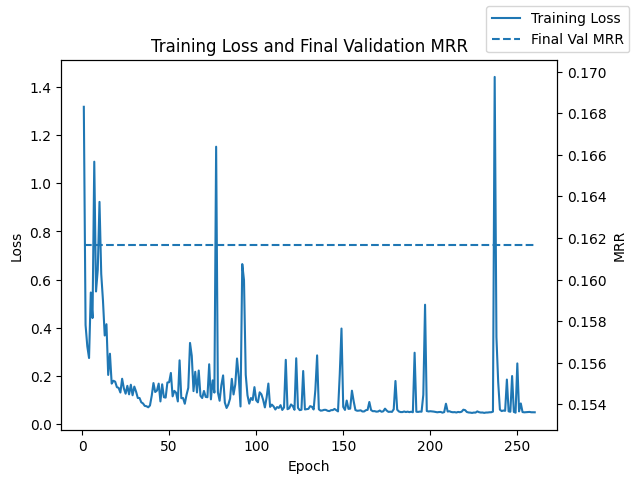

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss and final validation MRR
epochs = range(1, len(result.losses) + 1)
loss_history = result.losses

from pykeen.evaluation import RankBasedEvaluator

val_metrics = RankBasedEvaluator(filtered=True).evaluate(
    model=result.model,
    mapped_triples=validation.mapped_triples,
    additional_filter_triples=[training.mapped_triples],
)
final_mrr = val_metrics.get_metric('mean_reciprocal_rank')

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_history, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.hlines(final_mrr, xmin=1, xmax=len(loss_history), linestyles='--', label='Final Val MRR')
ax2.set_ylabel('MRR')

lines, labels = [], []
for axis in (ax1, ax2):
    l, lab = axis.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)
fig.legend(lines, labels, loc='upper right')

plt.title('Training Loss and Final Validation MRR')
plt.show()

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1244.78s seconds


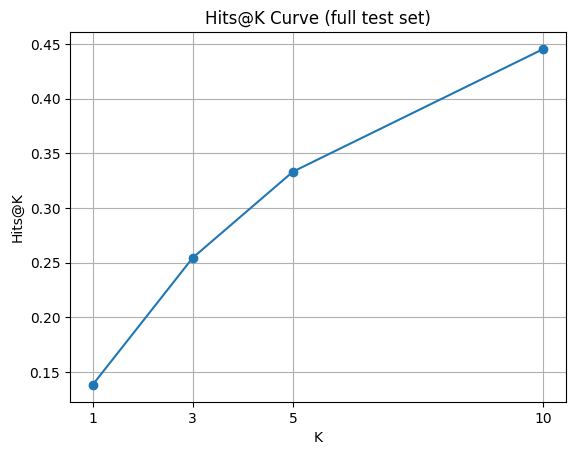

In [ ]:
from pykeen.evaluation import RankBasedEvaluator
import matplotlib.pyplot as plt

# Evaluate the model on the test set usinh Hits@K
rank_evaluator = RankBasedEvaluator(filtered=True)
rank_metrics = rank_evaluator.evaluate(
    model=result.model,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
    batch_size = 1024,
)

ks = [1, 3, 5, 10]
hits = [rank_metrics.get_metric(f'hits_at_{k}') for k in ks]

gplt = plt.figure()
plt.plot(ks, hits, marker='o')
plt.xlabel('K')
plt.ylabel('Hits@K')
plt.title('Hits@K Curve (full test set)')
plt.xticks(ks)
plt.grid(True)
plt.show()

In [30]:
print(torch.cuda.memory_summary())     

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 70           |        cudaMalloc retries: 70        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  19696 KiB |  41807 MiB |  31926 GiB |  31926 GiB |
|       from large pool |  19682 KiB |  41806 MiB |  31180 GiB |  31180 GiB |
|       from small pool |     13 KiB |      6 MiB |    746 GiB |    746 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  19696 KiB |  41807 MiB |  31926 GiB |  31926 GiB |
|       from large pool |  19682 KiB |  41806 MiB |  31180 GiB |

In [ ]:
import torch
print(torch.__version__)

2.7.0+cu118


### Training Metrics

In [ ]:
import optuna
import torch
import numpy as np
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

# Load the best model from the Optuna study
DB_URL     = "sqlite:///optuna_best_transe_checkpoints.db"
STUDY_NAME = "best_transE"
study = optuna.load_study(study_name=STUDY_NAME, storage=DB_URL)
best_no = study.best_trial.number

ckpt_path    = f"best_transe_model_trial_{best_no}.pt"
transE_model = torch.load(
    ckpt_path,
    weights_only=False,
    )
transE_model.eval()

evaluator = RankBasedEvaluator(filtered=True)
lp_train = evaluator.evaluate(
    model=transE_model,
    mapped_triples=training.mapped_triples,
    additional_filter_triples=[training.mapped_triples],
)

# Print the evaluation metrics
print("\n=== TRAIN LINK‐PREDICTION (TransE) ===")
print(f"Mean Rank:   {lp_train.get_metric('mean_rank'):.4f}")
print(f"Median Rank: {lp_train.get_metric('median_rank'):.4f}")
print(f"MRR:         {lp_train.get_metric('mean_reciprocal_rank'):.4f}")
for k in (1, 3, 5, 10):
    print(f"Hits@{k}:    {lp_train.get_metric(f'hits@{k}'):.4f}")

pos     = training.mapped_triples.numpy()
n       = pos.shape[0]
neg     = pos.copy()
num_ent = transE_model.num_entities
for i in range(n):
    if np.random.rand() < 0.5:
        neg[i, 0] = np.random.randint(num_ent)
    else:
        neg[i, 2] = np.random.randint(num_ent)

hrt_all = torch.tensor(np.vstack([pos, neg]), dtype=torch.long)
with torch.no_grad():
    scores = transE_model.score_hrt(hrt_all).cpu().numpy()

y_true   = np.concatenate([np.ones(n), np.zeros(n)])
prec, rec, thresholds = precision_recall_curve(y_true, scores)
f1s      = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1s)
best_thr = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

y_pred   = (scores >= best_thr).astype(int)
acc      = accuracy_score(y_true, y_pred)
prec_, rec_, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
roc_auc  = roc_auc_score(y_true, scores)

print("\n=== TRAIN CLASSIFICATION (TransE) ===")
print(f"Tuned threshold: {best_thr:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec_:.4f}")
print(f"Recall:          {rec_:.4f}")
print(f"F1:              {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")


Evaluating on cuda:0:   0%|          | 0.00/13.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 126.68s seconds



=== TRAIN LINK‐PREDICTION (TransE) ===
Mean Rank:   267.7064
Median Rank: 2.0000
MRR:         0.5571
Hits@1:    0.4966
Hits@3:    0.5735
Hits@5:    0.6077
Hits@10:    0.6869

=== TRAIN CLASSIFICATION (TransE) ===
Tuned threshold: -17.0255
Accuracy:        0.6945
Precision:       0.6460
Recall:          0.8607
F1:              0.7381
ROC-AUC:         0.8125


In [23]:
print(best_no)

5


### Testing Metrics

In [22]:
from pykeen.evaluation import RankBasedEvaluator
import torch
import numpy as np
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

evaluator = RankBasedEvaluator(filtered=True)
lp_test   = evaluator.evaluate(
    model=transE_model,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[
        training.mapped_triples,
        validation.mapped_triples,
    ],
)

# Print the ranking metrics for the test set
print("\n=== TEST LINK-PREDICTION (TransE) ===")
print(f"Mean Rank:   {lp_test.get_metric('mean_rank'):.4f}")
print(f"Median Rank: {lp_test.get_metric('median_rank'):.4f}")
print(f"MRR:         {lp_test.get_metric('mean_reciprocal_rank'):.4f}")
for k in (1, 3, 5, 10):
    print(f"Hits@{k}:    {lp_test.get_metric(f'hits@{k}'):.4f}")

pos        = testing.mapped_triples.numpy()
n          = pos.shape[0]
neg        = pos.copy()
num_ent    = transE_model.num_entities

for i in range(n):
    if np.random.rand() < 0.5:
        neg[i, 0] = np.random.randint(num_ent)
    else:
        neg[i, 2] = np.random.randint(num_ent)

hrt_all    = torch.tensor(np.vstack([pos, neg]), dtype=torch.long)
with torch.no_grad():
    scores   = transE_model.score_hrt(hrt_all).cpu().numpy()

y_true     = np.concatenate([np.ones(n), np.zeros(n)])
precisions, recalls, thresholds = precision_recall_curve(y_true, scores)
f1s        = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx   = np.argmax(f1s)
best_thr   = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
y_pred     = (scores >= best_thr).astype(int)

acc        = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary"
)
roc_auc    = roc_auc_score(y_true, scores)

print("\n=== TEST CLASSIFICATION (TransE) ===")
print(f"Tuned threshold: {best_thr:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1:              {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")


Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 153.62s seconds



=== TEST LINK-PREDICTION (TransE) ===
Mean Rank:   1562.3265
Median Rank: 8.0000
MRR:         0.3276
Hits@1:    0.2444
Hits@3:    0.3591
Hits@5:    0.4320
Hits@10:    0.5277

=== TEST CLASSIFICATION (TransE) ===
Tuned threshold: -19.7639
Accuracy:        0.6926
Precision:       0.6229
Recall:          0.9761
F1:              0.7605
ROC-AUC:         0.7280


### Top 20 Job Recommendations

In [ ]:
import pandas as pd
from pykeen.predict import predict_target

# Retrieve the resume ID from the Neo4j database
resume_id = run_query(
    """
    MATCH (r:Resume {name: $name})
    RETURN toString(id(r)) AS id
    """,
    {"name": "resume_1"},
)["id"][0]

relation_map = {
    'has_ability':       0,
    'has_knowledge':     1,
    'has_skill':         2,
    'has_work_activity': 3,
}

# Predicting the top 20 jobs for each relation type
dfs = []
for rel_label in relation_map:
    pred = (
        predict_target(
            model=transE_model,
            head=resume_id,
            relation=rel_label,
            triples_factory=training,  
        )
        .filter_triples(training)
    )
    topjobs = (
        pred.df
            .nlargest(20, "score")[["tail_id", "tail_label", "score"]]
            .assign(relation=rel_label)
    )
    dfs.append(topjobs)

combined = pd.concat(dfs, ignore_index=True)
combined = combined[combined["tail_id"].astype(str) != resume_id]

agg = (
    combined
    .groupby(["tail_id", "tail_label"])
    .agg(
        match_count = ("relation", "nunique"),
        total_score = ("score",    "sum"),
        matched_rels= ("relation", lambda rels: ", ".join(sorted(set(rels)))),
    )
    .reset_index()
)

top_jobs = (
    agg
    .sort_values(by=["match_count", "total_score"], ascending=[False, False])
    .head(20)
)

job_ids = top_jobs["tail_id"].tolist()
records = run_query(
    """
    UNWIND $ids AS id
    MATCH (j:Job)
      WHERE id(j) = id
    RETURN id(j) AS id, j.name AS name
    """,
    {"ids": job_ids},
)
id_to_name = dict(zip(records["id"].astype(int), records["name"]))
top_jobs["job_name"] = top_jobs["tail_id"].map(id_to_name)

print("\nTop recommended jobs (TransE Model):")
print(
    top_jobs[["job_name", "matched_rels", "match_count", "total_score"]]
        .to_string(index=False)
)


Top recommended jobs (TransE Model):
                                                                         job_name                                             matched_rels  match_count  total_score
                                              enterprise systems administration 1 has_ability, has_knowledge, has_skill, has_work_activity            4    -5.358732
                                             residential coordinator south austin has_ability, has_knowledge, has_skill, has_work_activity            4   -23.731948
                                                           deliver with uber eats has_ability, has_knowledge, has_skill, has_work_activity            4   -24.987992
                                                        warehouse worker parttime has_ability, has_knowledge, has_skill, has_work_activity            4   -25.392781
                                                                              NaN has_ability, has_knowledge, has_skill, has_work_activit

: 

## Model 2: CompGCN Model

### Connecting to Neo4j

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Connect to Neo4j database and retrieve the knowledge graph data
host = 'bolt://localhost:7687'
user = 'neo4j'
password = 'jobrecsys'
driver = GraphDatabase.driver(host,auth=(user, password))
                                         

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [ ]:
from pykeen.triples import TriplesFactory

# Query to get the triples from the Neo4j database
data = run_query("""
MATCH (s)-[r]->(t)
RETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type
""")

tf = TriplesFactory.from_labeled_triples(
    data[["source", "type", "target"]].values,
    create_inverse_triples=True,
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 17, offset: 36} for query: '\nMATCH (s)-[r]->(t)\nRETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 44, offset: 63} for query: '\nMATCH (s)-[r]->(t)\nRETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type\n'


In [3]:
training, testing, validation = tf.split([0.7, 0.1, 0.2])

using automatically assigned random_state=2088877851


In [14]:
import inspect
from pykeen.nn.representation import CombinedCompGCNRepresentations
print(inspect.signature(CombinedCompGCNRepresentations))


(*, triples_factory: 'CoreTriplesFactory', entity_representations: 'HintOrType[Representation]' = None, entity_representations_kwargs: 'OptionalKwargs' = None, relation_representations: 'HintOrType[Representation]' = None, relation_representations_kwargs: 'OptionalKwargs' = None, num_layers: 'int | None' = 1, dims: 'None | int | Sequence[int]' = None, layer_kwargs: 'Mapping[str, Any] | None' = None)


### Training the CompGCN Model

In [ ]:
import optuna
import torch
import torch.nn as nn
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator

# Load the best hyperparameters from the Optuna study
DB_URL     = "sqlite:///optuna_best_compgcn_checkpoints.db"
STUDY_NAME = "best_compgcn"

compgcn_model_store = {}

# Callback function to save the best CompGCN model
def save_full_compgcn_callback(study, trial):
    if study.best_trial == trial:
        model = compgcn_model_store[trial.number]
        fname = f"best_compgcn_model_trial_{trial.number}.pt"
        torch.save(model, fname)
        print(f"[Saved best CompGCN model: {fname}]")

# Hyperparameter ranges for the Optuna study
def objective(trial):
    embedding_dim = trial.suggest_int("embedding_dim", 50, 500)
    num_layers    = trial.suggest_int("num_layers", 2, 4)
    lr            = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)
    num_epochs    = trial.suggest_int("num_epochs", 50, 1000)
    batch_size = trial.suggest_int("batch_size", 16, 512, step=16)
    negs_per_pos  = trial.suggest_int("negs_per_pos", 1, 10)
    patience      = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_int("hidden_dim", 50, 500)
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)

    result = pipeline(
        model="CompGCN",
        loss="marginranking",
        loss_kwargs=dict(margin=1.0),
        negative_sampler="basic",
        negative_sampler_kwargs=dict(num_negs_per_pos=negs_per_pos),
        training=training,
        validation=validation,
        testing=testing,
        model_kwargs=dict(
            embedding_dim=embedding_dim,
            encoder_kwargs=dict(
                num_layers=num_layers,
                dims=hidden_dim,
                layer_kwargs=dict(dropout=dropout),
            ),
        ),
        optimizer="Adam",
        optimizer_kwargs=dict(lr=lr, weight_decay=weight_decay),
        training_kwargs=dict(
            num_epochs=num_epochs,
            batch_size=batch_size,
            use_tqdm_batch=False,
        ),
        stopper="early",
        stopper_kwargs=dict(
            metric="mean_reciprocal_rank",
            patience=patience,
            relative_delta=0.0,
        ),
        random_seed=42,
        evaluator=None,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    compgcn_model_store[trial.number] = result.model

    evaluator = RankBasedEvaluator(filtered=True)
    lp_val = evaluator.evaluate(
        model=result.model,
        mapped_triples=validation.mapped_triples,
        additional_filter_triples=[training.mapped_triples],
    )
    mrr = lp_val.get_metric("mean_reciprocal_rank")
    return float(mrr)

# Create/load the Optuna study 
if __name__ == "__main__":
    study = optuna.create_study(
        study_name=STUDY_NAME,
        storage=DB_URL,
        direction="maximize",
        load_if_exists=True,
    )
    study.optimize(
        objective,
        n_trials=10,
        show_progress_bar=True,
        callbacks=[save_full_compgcn_callback],
    )

    print(f"\nBest VAL MRR (CompGCN): {study.best_value:.4f}")
    print("Best params:", study.best_params)
    print(f"Best-model file: best_compgcn_model_trial_{study.best_trial.number}.pt")

[I 2025-05-20 01:45:20,323] Using an existing study with name 'best_compgcn' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/186 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/430 (0.23%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 38.33s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.015145501121878624. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-c779963b-2195-443c-8d34-e2e9aeef02b8.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 36.52s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.03987748548388481. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-c779963b-2195-443c-8d34-e2e9aeef02b8.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 39.22s seconds
INFO:pykeen.stoppers.early_stopping:New bes

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 18.68s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 42.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()


[I 2025-05-20 02:34:43,499] Trial 11 finished with value: 0.11049303412437439 and parameters: {'embedding_dim': 177, 'num_layers': 2, 'lr': 0.0008830124098320152, 'weight_decay': 0.00011468778075021206, 'num_epochs': 186, 'batch_size': 64, 'negs_per_pos': 2, 'patience': 8, 'hidden_dim': 328, 'dropout': 0.20285825180043737}. Best is trial 11 with value: 0.11049303412437439.
[Saved best CompGCN model: best_compgcn_model_trial_11.pt]


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-08867f6c-2e39-47b1-a41a-4179f55efd7a.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/79 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/90 (1.11%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 9.43s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.011590475216507912. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-08867f6c-2e39-47b1-a41a-4179f55efd7a.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.48s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.018095476552844048. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-08867f6c-2e39-47b1-a41a-4179f55efd7a.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.73s seconds
INFO:pykeen.stoppers.early_stopping:New best r

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.59s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 9.88s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()


[I 2025-05-20 02:41:44,765] Trial 12 finished with value: 0.08380280435085297 and parameters: {'embedding_dim': 410, 'num_layers': 3, 'lr': 0.00044993965678145166, 'weight_decay': 0.0033159444314400594, 'num_epochs': 79, 'batch_size': 304, 'negs_per_pos': 5, 'patience': 3, 'hidden_dim': 90, 'dropout': 0.2905507219532335}. Best is trial 11 with value: 0.11049303412437439.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-12a69304-e812-4d01-908a-875c8e2bbcb7.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/653 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/101 (0.99%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 19.61s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.005697572138160467. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-12a69304-e812-4d01-908a-875c8e2bbcb7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 19.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.012298023328185081. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-12a69304-e812-4d01-908a-875c8e2bbcb7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 18.67s seconds
INFO:pykeen.stoppers.early_stopping:New be

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.59s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 25.48s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


[I 2025-05-20 02:58:20,590] Trial 13 finished with value: 0.12606728076934814 and parameters: {'embedding_dim': 414, 'num_layers': 2, 'lr': 0.0005117292637315422, 'weight_decay': 0.0007854869913023926, 'num_epochs': 653, 'batch_size': 272, 'negs_per_pos': 4, 'patience': 9, 'hidden_dim': 122, 'dropout': 0.2262131619201525}. Best is trial 13 with value: 0.12606728076934814.
[Saved best CompGCN model: best_compgcn_model_trial_13.pt]


INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-ae829d9e-5c7f-4172-922d-bdc927c8bcee.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/67 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/82 (1.22%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 17.97s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.018540002405643463. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-ae829d9e-5c7f-4172-922d-bdc927c8bcee.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 19.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.042704399675130844. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-ae829d9e-5c7f-4172-922d-bdc927c8bcee.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 18.56s seconds
INFO:pykeen.stoppers.early_stopping:New bes

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.41s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 18.08s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()


[I 2025-05-20 03:04:11,518] Trial 14 finished with value: 0.07025448977947235 and parameters: {'embedding_dim': 341, 'num_layers': 3, 'lr': 0.0005377364939226961, 'weight_decay': 0.0035509201502716514, 'num_epochs': 67, 'batch_size': 336, 'negs_per_pos': 10, 'patience': 5, 'hidden_dim': 186, 'dropout': 0.09210215709189434}. Best is trial 13 with value: 0.12606728076934814.


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-5b05d2de-74a9-4c46-8bf1-65cbf020bc57.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/387 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/123 (0.81%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 17.44s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.008676928468048573. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-5b05d2de-74a9-4c46-8bf1-65cbf020bc57.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.34s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.017656808719038963. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-5b05d2de-74a9-4c46-8bf1-65cbf020bc57.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 16.96s seconds
INFO:pykeen.stoppers.early_stopping:New be

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 13.61s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 30.11s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.nn.representation:Inferred unique=True for SingleCompGCNRepresentation()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-3209d9ff-3a46-4463-aae8-ae6c63926b14.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


[I 2025-05-20 05:08:44,122] Trial 15 finished with value: 0.10738283395767212 and parameters: {'embedding_dim': 382, 'num_layers': 2, 'lr': 0.0005949337256560763, 'weight_decay': 0.05977924351037643, 'num_epochs': 387, 'batch_size': 224, 'negs_per_pos': 1, 'patience': 5, 'hidden_dim': 170, 'dropout': 0.48097009236690785}. Best is trial 13 with value: 0.12606728076934814.


Training epochs on cuda:0:   0%|          | 0/123 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/57 (1.75%) batches).


[W 2025-05-20 05:17:34,089] Trial 16 failed with parameters: {'embedding_dim': 300, 'num_layers': 3, 'lr': 0.068137381153775, 'weight_decay': 0.001721362989407732, 'num_epochs': 123, 'batch_size': 480, 'negs_per_pos': 10, 'patience': 3, 'hidden_dim': 409, 'dropout': 0.1848243677926758} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Keerthana\Documents\FYP\JobRecommendationSystem\jobrecsys\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Keerthana\AppData\Local\Temp\ipykernel_55516\2062594779.py", line 31, in objective
    result = pipeline(
             ^^^^^^^^^
  File "c:\Users\Keerthana\Documents\FYP\JobRecommendationSystem\jobrecsys\Lib\site-packages\pykeen\pipeline\api.py", line 1540, in pipeline
    stopper_instance, configuration, losses, train_seconds = _handle_training(
                                              

KeyboardInterrupt: 

In [ ]:
import optuna
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
import torch

# Load the best hyperparameters from the Optuna study
DB_URL     = "sqlite:///optuna_best_compgcn_checkpoints.db"
STUDY_NAME = "best_compgcn"
study = optuna.load_study(study_name=STUDY_NAME, storage=DB_URL)
best_hparams = study.best_params

# Re-run the pipeline with the best hyperparameters
result = pipeline(
    model="CompGCN",
    loss="marginranking",
    loss_kwargs=dict(margin=1.0),
    negative_sampler="basic",
    negative_sampler_kwargs=dict(num_negs_per_pos=best_hparams["negs_per_pos"]),
    training=training,
    validation=validation,
    testing=testing,
    model_kwargs=dict(
        embedding_dim=best_hparams["embedding_dim"],
        encoder_kwargs=dict(
            num_layers=best_hparams["num_layers"],
            dims=best_hparams["hidden_dim"],
            layer_kwargs=dict(dropout=best_hparams["dropout"]),
        ),
    ),
    optimizer="Adam",
    optimizer_kwargs=dict(
        lr=best_hparams["lr"],
        weight_decay=best_hparams["weight_decay"],
    ),
    training_kwargs=dict(
        num_epochs=best_hparams["num_epochs"],
        batch_size=best_hparams["batch_size"],
        use_tqdm_batch=False,
    ),
    stopper="early",
    stopper_kwargs=dict(
        metric="mean_reciprocal_rank",
        patience=best_hparams["patience"],
        relative_delta=0.0,
    ),
    random_seed=42,
    evaluator=RankBasedEvaluator(filtered=True),
    device="cuda" if torch.cuda.is_available() else "cpu",
)


INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/653 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/101 (0.99%) batches).
INFO:pykeen.evaluation.evaluator:Evaluation took 16.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.006580162327736616. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-39ad5e57-fc05-4e56-af50-3d551cc0de28.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.evaluation.evaluator:Evaluation took 18.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.010782892815768719. Saved model weights to C:\Users\Keerthana\.data\pykeen\checkpoints\best-model-weights-39ad5e57-fc05-4e56-af50-3d551cc0de28.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.31s seconds
INFO:pykeen.stoppers.early_stopping:New be

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.35s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 25.32s seconds


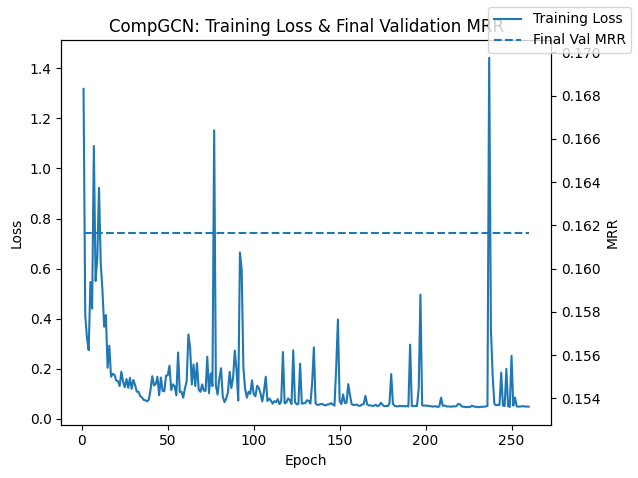

In [ ]:
import matplotlib.pyplot as plt
from pykeen.evaluation import RankBasedEvaluator

epochs = range(1, len(result.losses) + 1)
loss_history = result.losses

# Plotting the training loss and final validation MRR
val_metrics = RankBasedEvaluator(filtered=True).evaluate(
    model=result.model,
    mapped_triples=validation.mapped_triples,
    additional_filter_triples=[training.mapped_triples],
)
final_mrr = val_metrics.get_metric('mean_reciprocal_rank')

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_history, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.hlines(final_mrr, xmin=1, xmax=len(loss_history),
           linestyles='--', label='Final Val MRR')
ax2.set_ylabel('MRR')

lines, labels = [], []
for ax in (ax1, ax2):
    l, lab = ax.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)
fig.legend(lines, labels, loc='upper right')

plt.title('CompGCN: Training Loss & Final Validation MRR')
plt.tight_layout()
plt.show()


Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds


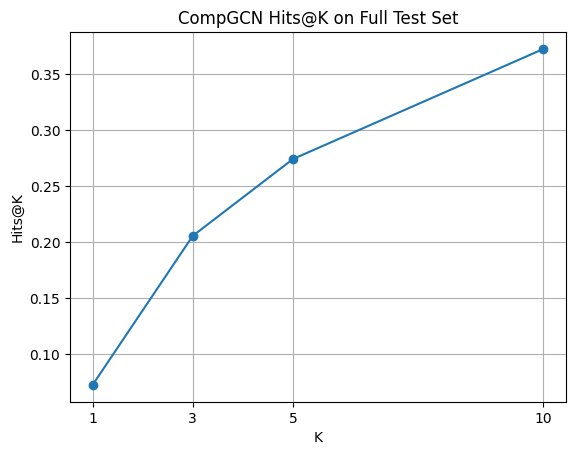

In [ ]:
from pykeen.evaluation import RankBasedEvaluator
import matplotlib.pyplot as plt

# Evaluate the model on the test set using filtered MRR
rank_evaluator = RankBasedEvaluator(filtered=True)
rank_metrics = rank_evaluator.evaluate(
    model=result.model,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[
        training.mapped_triples,
        validation.mapped_triples,
    ],
    batch_size=1024,
)

ks = [1, 3, 5, 10]
hits = [rank_metrics.get_metric(f"hits_at_{k}") for k in ks]

plt.figure()
plt.plot(ks, hits, marker="o")
plt.xlabel("K")
plt.ylabel("Hits@K")
plt.title("CompGCN Hits@K on Full Test Set")
plt.xticks(ks)
plt.grid(True)
plt.show()

### Training Metrics

In [ ]:
import optuna
import torch
import numpy as np
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

# Load the best model from the Optuna study
DB_URL     = "sqlite:///optuna_best_compgcn_checkpoints.db"
STUDY_NAME = "best_compgcn"
study = optuna.load_study(study_name=STUDY_NAME, storage=DB_URL)
best_no = study.best_trial.number

# Load the CompGCN model
ckpt_path      = f"best_compgcn_model_trial_{best_no}.pt"
compgcn_model  = torch.load(ckpt_path, weights_only=False)
compgcn_model.eval()

# Evaluate the model on the training set using filtered MRR
evaluator = RankBasedEvaluator(filtered=True)
lp_train = evaluator.evaluate(
    model=compgcn_model,
    mapped_triples=training.mapped_triples,
    additional_filter_triples=[training.mapped_triples],
)

# Print the ranking metrics for the training set
print("\n=== TRAIN LINK-PREDICTION (CompGCN) ===")
print(f"Mean Rank:   {lp_train.get_metric('mean_rank'):.4f}")
print(f"Median Rank: {lp_train.get_metric('median_rank'):.4f}")
print(f"MRR:         {lp_train.get_metric('mean_reciprocal_rank'):.4f}")
for k in (1, 3, 5, 10):
    print(f"Hits@{k}:    {lp_train.get_metric(f'hits_at_{k}'):.4f}")

# Generate negative samples for classification
pos     = training.mapped_triples.numpy()
n       = pos.shape[0]
neg     = pos.copy()
num_ent = compgcn_model.num_entities
for i in range(n):
    if np.random.rand() < 0.5:
        neg[i, 0] = np.random.randint(num_ent) 
    else:
        neg[i, 2] = np.random.randint(num_ent)

hrt_all = torch.tensor(np.vstack([pos, neg]), dtype=torch.long)
with torch.no_grad():
    scores = compgcn_model.score_hrt(hrt_all).cpu().numpy()

# Calculate classification metrics
y_true   = np.concatenate([np.ones(n), np.zeros(n)])
prec, rec, thresholds = precision_recall_curve(y_true, scores)
f1s      = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

y_pred   = (scores >= best_thr).astype(int)
acc      = accuracy_score(y_true, y_pred)
prec_, rec_, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
roc_auc  = roc_auc_score(y_true, scores)

# Print the classification metrics
print("\n=== TRAIN CLASSIFICATION (CompGCN) ===")
print(f"Tuned threshold: {best_thr:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec_:.4f}")
print(f"Recall:          {rec_:.4f}")
print(f"F1:              {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")

Evaluating on cuda:0:   0%|          | 0.00/13.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 87.31s seconds



=== TRAIN LINK-PREDICTION (CompGCN) ===
Mean Rank:   225.6376
Median Rank: 4.0000
MRR:         0.4839
Hits@1:    0.3991
Hits@3:    0.4465
Hits@5:    0.6049
Hits@10:    0.7185

=== TRAIN CLASSIFICATION (CompGCN) ===
Tuned threshold: 0.0555
Accuracy:        0.7196
Precision:       0.7684
Recall:          0.6286
F1:              0.6915
ROC-AUC:         0.6342


### Testing Metrics

In [ ]:
from pykeen.evaluation import RankBasedEvaluator
import torch
import numpy as np
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

evaluator = RankBasedEvaluator(filtered=True)
lp_test = evaluator.evaluate(
    model=compgcn_model,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[
        training.mapped_triples,
        validation.mapped_triples,
    ],
    batch_size=1024,
)

# Print the ranking metrics for the test set
print("\n=== TEST LINK-PREDICTION (CompGCN) ===")
print(f"Mean Rank:   {lp_test.get_metric('mean_rank'):.4f}")
print(f"Median Rank: {lp_test.get_metric('median_rank'):.4f}")
print(f"MRR:         {lp_test.get_metric('mean_reciprocal_rank'):.4f}")
for k in (1, 3, 5, 10):
    print(f"Hits@{k}:    {lp_test.get_metric(f'hits_at_{k}'):.4f}")

# Generate negative samples for classification and calculate scores
pos     = testing.mapped_triples.numpy()
n       = pos.shape[0]
neg     = pos.copy()
num_ent = compgcn_model.num_entities

for i in range(n):
    if np.random.rand() < 0.5:
        neg[i, 0] = np.random.randint(num_ent)
    else:
        neg[i, 2] = np.random.randint(num_ent)

hrt_all = torch.tensor(np.vstack([pos, neg]), dtype=torch.long)
with torch.no_grad():
    scores = compgcn_model.score_hrt(hrt_all).cpu().numpy()

y_true     = np.concatenate([np.ones(n), np.zeros(n)])
precisions, recalls, thresholds = precision_recall_curve(y_true, scores)
f1s        = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx   = np.nanargmax(f1s)
best_thr   = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
y_pred     = (scores >= best_thr).astype(int)

acc       = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
roc_auc   = roc_auc_score(y_true, scores)

# Print the classification metrics
print("\n=== TEST CLASSIFICATION (CompGCN) ===")
print(f"Tuned threshold: {best_thr:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1:              {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")

Evaluating on cuda:0:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.04s seconds



=== TEST LINK-PREDICTION (CompGCN) ===
Mean Rank:   1632.4944
Median Rank: 17.0000
MRR:         0.1959
Hits@1:    0.1094
Hits@3:    0.2074
Hits@5:    0.2855
Hits@10:    0.4084

=== TEST CLASSIFICATION (CompGCN) ===
Tuned threshold: -2.1911
Accuracy:        0.5003
Precision:       0.5001
Recall:          1.0000
F1:              0.6668
ROC-AUC:         0.4137


### Top 20 Job Recommendations

In [ ]:
import pandas as pd
from pykeen.predict import predict_target

# Load the resume ID from the Neo4j database
resume_id = run_query(
    """
    MATCH (r:Resume {name: $name})
    RETURN toString(id(r)) AS id
    """,
    {"name": "resume_1"},
)["id"][0]

relation_map = {
    'has_ability':       0,
    'has_knowledge':     1,
    'has_skill':         2,
    'has_work_activity': 3,
}

# Predicting the top 20 jobs for each relation type
dfs = []
for rel_label in relation_map:
    pred = (
        predict_target(
            model=compgcn_model, 
            head=resume_id,
            relation=rel_label,
            triples_factory=training, 
        )
        .filter_triples(training) 
    )
    top_tails = (
        pred.df
            .nlargest(20, "score")[["tail_id", "tail_label", "score"]]
            .assign(relation=rel_label)
    )
    dfs.append(top_tails)

combined = pd.concat(dfs, ignore_index=True)
combined = combined[combined["tail_id"].astype(str) != resume_id]

# Grouping and aggregating the results
agg = (
    combined
    .groupby(["tail_id", "tail_label"])
    .agg(
        match_count = ("relation", "nunique"),
        total_score = ("score",    "sum"),
        matched_rels= ("relation", lambda rels: ", ".join(sorted(set(rels)))),
    )
    .reset_index()
)

top_entities = (
    agg
    .sort_values(by=["match_count", "total_score"], ascending=[False, False])
    .head(20)
)

# Fetching job names for the top entities
entity_ids = top_entities["tail_id"].tolist()
records = run_query(
    """
    UNWIND $ids AS id
    MATCH (j:Job)
      WHERE id(j) = id
    RETURN id(j) AS id, j.name AS name
    """,
    {"ids": entity_ids},
)
id_to_name = dict(zip(records["id"].astype(int), records["name"]))
top_entities["job_name"] = top_entities["tail_id"].map(id_to_name)

print("\nTop recommended jobs (CompGCN Model):")
print(
    top_entities[["job_name", "matched_rels", "match_count", "total_score"]]
        .to_string(index=False)
)


Top recommended jobs (CompGCN Model):
                                                                    job_name                          matched_rels  match_count  total_score
                                                   store manager in training has_ability, has_knowledge, has_skill            3     0.129954
                                    heavy equipment operator  minneapolis mn has_ability, has_knowledge, has_skill            3     0.120426
                                                         amazon pickerpacker has_ability, has_knowledge, has_skill            3     0.114229
                           customer service representative full or part time has_ability, has_knowledge, has_skill            3     0.107079
                                                              amazon shopper has_ability, has_knowledge, has_skill            3     0.104949
                                                      deliver with uber eats has_ability, has_knowledge, has_skill 

## Model 3: TransE + CompGCN ensemble model (Ensemble Model)

### Combining TransE + CompGCN models at Inference Time

In [ ]:
import torch
import optuna
import numpy as np
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

# Load the best models from the Optuna studies
def load_best_model(db_url: str, study_name: str, prefix: str) -> torch.nn.Module:
    study   = optuna.load_study(study_name=study_name, storage=db_url)
    best_no = study.best_trial.number
    path    = f"{prefix}_model_trial_{best_no}.pt"
    model   = torch.load(path, map_location="cpu", weights_only=False)
    model.eval()
    return model

transE_model  = load_best_model(
    "sqlite:///optuna_best_transe_checkpoints.db",
    "best_transE",
    "best_transe",
)
compgcn_model = load_best_model(
    "sqlite:///optuna_best_compgcn_checkpoints.db",
    "best_compgcn",
    "best_compgcn",
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transE_model.to(device)
compgcn_model.to(device)

# Define the ensemble model
class EnsembleModel(torch.nn.Module):
    def __init__(self, m1, m2, alpha, *, device, num_entities, num_relations):
        super().__init__()
        self.add_module("m1", m1)
        self.add_module("m2", m2)
        self.alpha = alpha        
        self.device = device 
        self.num_entities = num_entities
        self.num_relations = num_relations

    def score_hrt(self, hrt_batch: torch.LongTensor) -> torch.FloatTensor:
        device = next(self.m1.parameters()).device
        hrt = hrt_batch.to(device)
        s1 = self.m1.score_hrt(hrt)
        s2 = self.m2.score_hrt(hrt)
        return self.alpha * s1 + (1.0 - self.alpha) * s2
    
    def predict(self, *args, **kwargs) -> torch.FloatTensor:
        s1 = self.m1.predict(*args, **kwargs)
        s2 = self.m2.predict(*args, **kwargs)
        return self.alpha * s1 + (1.0 - self.alpha) * s2
    

num_entities  = transE_model.num_entities
num_relations = transE_model.num_relations

device = torch.device("cpu")
transE_model.to(device)
compgcn_model.to(device)

evaluator = RankBasedEvaluator(filtered=True)
alphas     = np.linspace(0, 1, 11)
val_mrrs   = []

# Evaluate the ensemble model for different alpha values
for a in alphas:
    ensemble = EnsembleModel(
        transE_model,
        compgcn_model,
        alpha=a,              
        device=device,
        num_entities=num_entities,
        num_relations=num_relations,
    ).to(device)
    ensemble.device = device

    vm = evaluator.evaluate(
        model=ensemble,
        mapped_triples=validation.mapped_triples,
        additional_filter_triples=[training.mapped_triples],
    )
    val_mrrs.append(vm.get_metric("mean_reciprocal_rank"))

# Print the results for the best alpha and its corresponding MRR
best_idx   = int(np.nanargmax(val_mrrs))
best_alpha = alphas[best_idx]
print(f"Best alpha = {best_alpha:.2f} with VAL MRR = {val_mrrs[best_idx]:.4f}")

ensemble = EnsembleModel(
    transE_model,
    compgcn_model,
    best_alpha,
    device=device,
    num_entities=num_entities,
    num_relations=num_relations,
).to(device)

metrics = evaluator.evaluate(
    model=ensemble,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
)

# Calculate and print the classification metrics for the test set
pos = testing.mapped_triples.numpy()
n   = pos.shape[0]
neg = pos.copy()
for i in range(n):
    if np.random.rand() < 0.5:
        neg[i, 0] = np.random.randint(num_entities)
    else:
        neg[i, 2] = np.random.randint(num_entities)

hrt_all = torch.tensor(np.vstack([pos, neg]), dtype=torch.long)
y_all   = np.concatenate([np.ones(n), np.zeros(n)])

with torch.no_grad():
    scores = ensemble.score_hrt(hrt_all).cpu().numpy()

precisions, recalls, thresholds = precision_recall_curve(y_all, scores)
f1s     = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_i  = int(np.nanargmax(f1s))
best_thr= float(thresholds[best_i] if best_i < len(thresholds) else thresholds[-1])

y_pred = (scores >= best_thr).astype(int)
acc     = accuracy_score(y_all, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_all, y_pred, average="binary")
roc_auc = roc_auc_score(y_all, scores)

Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.34s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.55s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.60s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.48s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.29s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 12.05s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 13.86s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 14.89s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.56s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.60s seconds


Evaluating on cpu:   0%|          | 0.00/3.94k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.59s seconds


Best alpha = 0.60 with VAL MRR = 0.3114


Evaluating on cpu:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 7.92s seconds


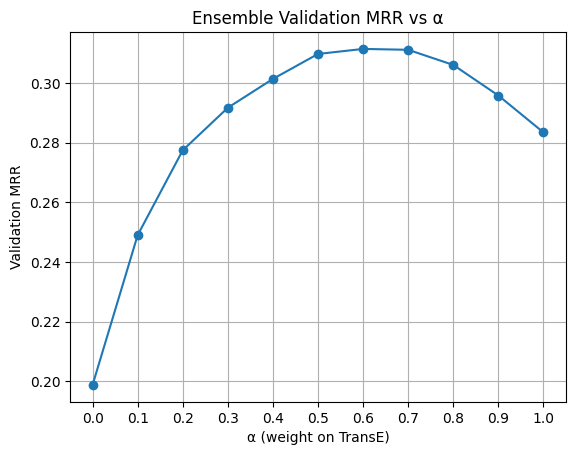

In [ ]:
import matplotlib.pyplot as plt

# Plotting the validation MRR vs alpha
plt.figure()
plt.plot(alphas, val_mrrs, marker='o')
plt.xlabel('α (weight on TransE)')
plt.ylabel('Validation MRR')
plt.title('Ensemble Validation MRR vs α')
plt.xticks(alphas)
plt.grid(True)
plt.show()


Evaluating on cpu:   0%|          | 0.00/1.97k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 5.77s seconds


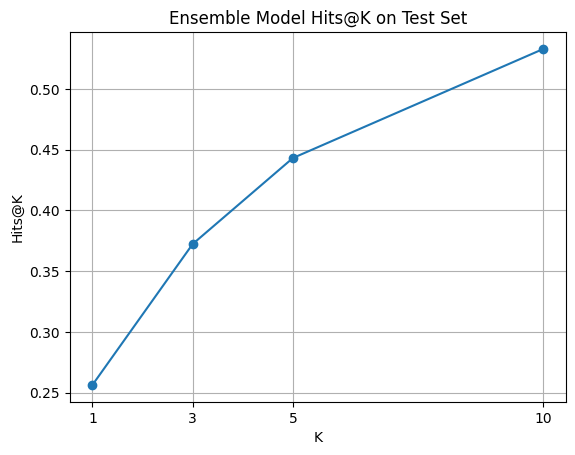

In [ ]:
import matplotlib.pyplot as plt
from pykeen.evaluation import RankBasedEvaluator

# Plotting Hits@K for the ensemble model
evaluator = RankBasedEvaluator(filtered=True)
test_metrics = evaluator.evaluate(
    model=ensemble,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
)

ks   = [1, 3, 5, 10]
hits = [test_metrics.get_metric(f"hits@{k}") for k in ks]

plt.figure()
plt.plot(ks, hits, marker="o")
plt.xlabel("K")
plt.ylabel("Hits@K")
plt.title("Ensemble Model Hits@K on Test Set")
plt.xticks(ks)
plt.grid(True)
plt.show()


### Testing Metrics

In [ ]:
# Print the metrics for the test set
print("\n=== TEST LINK-PREDICTION (TransE + CompGCN Ensemble Model) ===")
print(f"Mean Rank:   {metrics.get_metric('mean_rank'):.4f}")
print(f"Median Rank: {metrics.get_metric('median_rank'):.4f}")
print(f"MRR:         {metrics.get_metric('mean_reciprocal_rank'):.4f}")
for k in (1, 3, 5, 10):
    print(f"Hits@{k}:    {metrics.get_metric(f'hits@{k}'): .4f}")

print()

print("\n=== TEST CLASSIFICATION (TransE + CompGCN Ensemble Model) ===")
print(f"Tuned threshold: {best_thr:.4f}")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1:              {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")



=== TEST LINK-PREDICTION (TransE + CompGCN Ensemble Model) ===
Mean Rank:   1270.0579
Median Rank: 8.0000
MRR:         0.3390
Hits@1:     0.2563
Hits@3:     0.3723
Hits@5:     0.4431
Hits@10:     0.5330


=== TEST CLASSIFICATION (TransE + CompGCN Ensemble Model) ===
Tuned threshold: -11.9737
Accuracy:        0.6959
Precision:       0.6257
Recall:          0.9751
F1:              0.7623
ROC-AUC:         0.7255


### Top 20 Job Recommendations

In [17]:
import pandas as pd
from pykeen.predict import predict_target

resume_id = run_query(
    """
    MATCH (r:Resume {name: $name})
    RETURN toString(id(r)) AS id
    """,
    {"name": "resume_1"},
)["id"][0]

relation_map = {
    'has_ability':       0,
    'has_knowledge':     1,
    'has_skill':         2,
    'has_work_activity': 3,
}

dfs = []
for rel_label in relation_map:
    pred = (
        predict_target(
            model=ensemble,
            head=resume_id,
            relation=rel_label,
            triples_factory=training,
        )
        .filter_triples(training) 
    )
    top_tails = (
        pred.df
            .nlargest(20, "score")[["tail_id", "tail_label", "score"]]
            .assign(relation=rel_label)
    )
    dfs.append(top_tails)

combined = pd.concat(dfs, ignore_index=True)
combined = combined[combined["tail_id"].astype(str) != resume_id]

agg = (
    combined
    .groupby(["tail_id", "tail_label"])
    .agg(
        match_count = ("relation", "nunique"),
        total_score = ("score",    "sum"),
        matched_rels= ("relation", lambda rels: ", ".join(sorted(set(rels)))),
    )
    .reset_index()
)

top_entities = (
    agg
    .sort_values(by=["match_count", "total_score"], ascending=[False, False])
    .head(20)
)

entity_ids = top_entities["tail_id"].tolist()
records = run_query(
    """
    UNWIND $ids AS id
    MATCH (j:Job)
      WHERE id(j) = id
    RETURN id(j) AS id, j.name AS name
    """,
    {"ids": entity_ids},
)
id_to_name = dict(zip(records["id"].astype(int), records["name"]))

top_entities["job_name"] = top_entities["tail_id"].astype(int).map(id_to_name)

print("\nTop recommended jobs (TransE + CompGCN Ensemble Model):")
print(
    top_entities[["job_name", "matched_rels", "match_count", "total_score"]]
        .to_string(index=False)
)


Top recommended jobs (TransE + CompGCN Ensemble Model):
                                                                         job_name                                             matched_rels  match_count  total_score
                                             residential coordinator south austin has_ability, has_knowledge, has_skill, has_work_activity            4    -1.471982
                                              enterprise systems administration 1 has_ability, has_knowledge, has_skill, has_work_activity            4    -3.310104
                                                   registered nurse rn no license has_ability, has_knowledge, has_skill, has_work_activity            4   -14.762510
                                                        general labor  pick  pack                has_ability, has_skill, has_work_activity            3    -8.808328
                                          retail security officer for valley fair            has_ability, has_knowledg